In [1]:
import boa
import matplotlib.pyplot as plt

from utils import deploy_infra, deploy_pool

## **Table of Content**

1. [Infrastrucutre and Pool Setup](#infrastrucutre-and-pool-setup)
2. [Ramping A and Gamma](#2-ramping-a-and-gamma)
3. [Stop Ramping A and Gamma](#3-stop-ramping-a-and-gamma)
4. [Applying New Parameters](#4-applying-new-parameters)

### **1. Infrastructure and Pool Setup**

To illustrate the process of modifying pool parameters, the first step involves deploying the twocrypto infrastructure alongside a specific pool. This is executed via the imported functions `deploy_infra` and `deploy_pool` from the utils script.

This deploys the Factory along with its associated implementations (AMM, Gauge, Math, Views), followed by the deployment of a liquidity pool featuring `coin_a` and `coin_b`.


In [2]:
# deploying infrastructure for twocrypto-ng pools
infra = deploy_infra()
factory = infra["factory"]
admin = infra["admin"]
coin_a = infra["coin_a"]
coin_b = infra["coin_b"]

# deploy pool using coin_a and coin_b
pool = deploy_pool(factory, coin_a, coin_b)
pool = infra["impl"].at(pool)
pool

/Users/mo/.pyenv/versions/3.12.2/envs/boa/lib/python3.12/site-packages/vyper/ast/folding.py:153: UserWarning: ZERO_ADDRESS is deprecated. Please use `empty(address)` instead.
  warnings.warn(f"{name} is deprecated. Please use `{replacement}` instead.")
/Users/mo/.pyenv/versions/3.12.2/envs/boa/lib/python3.12/site-packages/vyper/semantics/types/subscriptable.py:115: UserWarning: Use of large arrays can be unsafe!
  warnings.warn("Use of large arrays can be unsafe!")


<../contracts/main/CurveTwocryptoOptimized.vy at 0x5Bac22268eecccDF2fa09D03eC0D0fDbA2848ba2, compiled with vyper-0.3.10+9136169>
<storage: cached_price_scale=1000000000000000000, cached_price_oracle=1000000000000000000, cached_xcp_oracle=0, last_prices=1000000000000000000, last_timestamp=581410985362807579415732113334439372111543230154, last_xcp=0, xcp_ma_time=62324, initial_A_gamma=136112946768375385385349842972852284582400000, initial_A_gamma_time=0, future_A_gamma=136112946768375385385349842972852284582400000, future_A_gamma_time=0, balances=[0, 0], D=0, xcp_profit=0, xcp_profit_a=1000000000000000000, virtual_price=0, packed_rebalancing_params=680564733841876929619973849625130958848000000000865, packed_fee_params=8847341539944400050877843276543133320576000000, last_admin_fee_claim_timestamp=0, admin_lp_virtual_balance=0, balanceOf={}, allowance={}, totalSupply=0, nonces={}>

### **2. Ramping A and Gamma**

A and gamma values can only be ramped by the `admin` of the Factory.


- #### `ramp_A_gamma(future_A: uint256, future_gamma: uint256, future_time: uint256):`

    Function to linearly ramp the values of `A` and `gamma`. Both `A` and `gamma` are packed within the same variable.

    Emits: `RampAgamma`

    | Input          | Type      | Description           |
    | -------------- | --------- | --------------------- |
    | `future_A`     | `uint256` | Future value of `A`   |
    | `future_gamma` | `uint256` | Future value of `gamma` |
    | `future_time`  | `uint256` | Timestamp at which the ramping will end |


    When ramping A/gamma, `future_A` and `future_gamma` values are packed and stored into a single uint256 variable (`future_A_gamma`).

In [3]:
BITWISE_MASK_128 = (2**128 - 1)

# fetch current timestamp
ts = boa.env.vm.patch.timestamp

# get A and gamma
future_A_gamma_raw = pool.future_A_gamma()
A_initial = future_A_gamma_raw >> 128
gamma_initial = future_A_gamma_raw & BITWISE_MASK_128

print(f"raw future_A_gamma: {future_A_gamma_raw}")
print(f"A (unpacked): {A_initial}")
print(f"gamma (unpacked): {gamma_initial}")
print(f"current timestamp: {ts}")
print("---------------")

# ramp A and gamma
try:
    with boa.env.prank(admin):
        # now we ramp A and gamma over 1d
        pool.ramp_A_gamma(1200000, 200000000000000, ts + 86400)
    print("Ramp initiated successfully.")
except Exception as e:
    print(f"Failed to ramp A and gamma: {e}")

# get A and gamma after initializing the ramp
future_A_gamma_raw_after = pool.future_A_gamma()
A_after = future_A_gamma_raw_after >> 128
gamma_after = future_A_gamma_raw_after & BITWISE_MASK_128

print("---------------")
print(f"raw future_A_gamma: {future_A_gamma_raw_after}")
print(f"A (unpacked): {A_after}")
print(f"gamma (unpacked): {gamma_after}")
print(f"ramp finished: {pool.future_A_gamma_time()}")

# store values
A = []
gamma = []
timestamps = []

# Increment timestamps and save new A and gamma value
for current_time in range(ts, ts + 95000, 2500):
    A.append(pool.A())
    gamma.append(pool.gamma())
    timestamps.append(current_time)
    boa.env.time_travel(2500)


raw future_A_gamma: 136112946768375385385349842972852284582400000
A (unpacked): 400000
gamma (unpacked): 145000000000000
current timestamp: 1708613322
---------------
Ramp initiated successfully.
---------------
raw future_A_gamma: 408338840305126156156049528918321853747200000
A (unpacked): 1200000
gamma (unpacked): 200000000000000
ramp finished: 1708699722


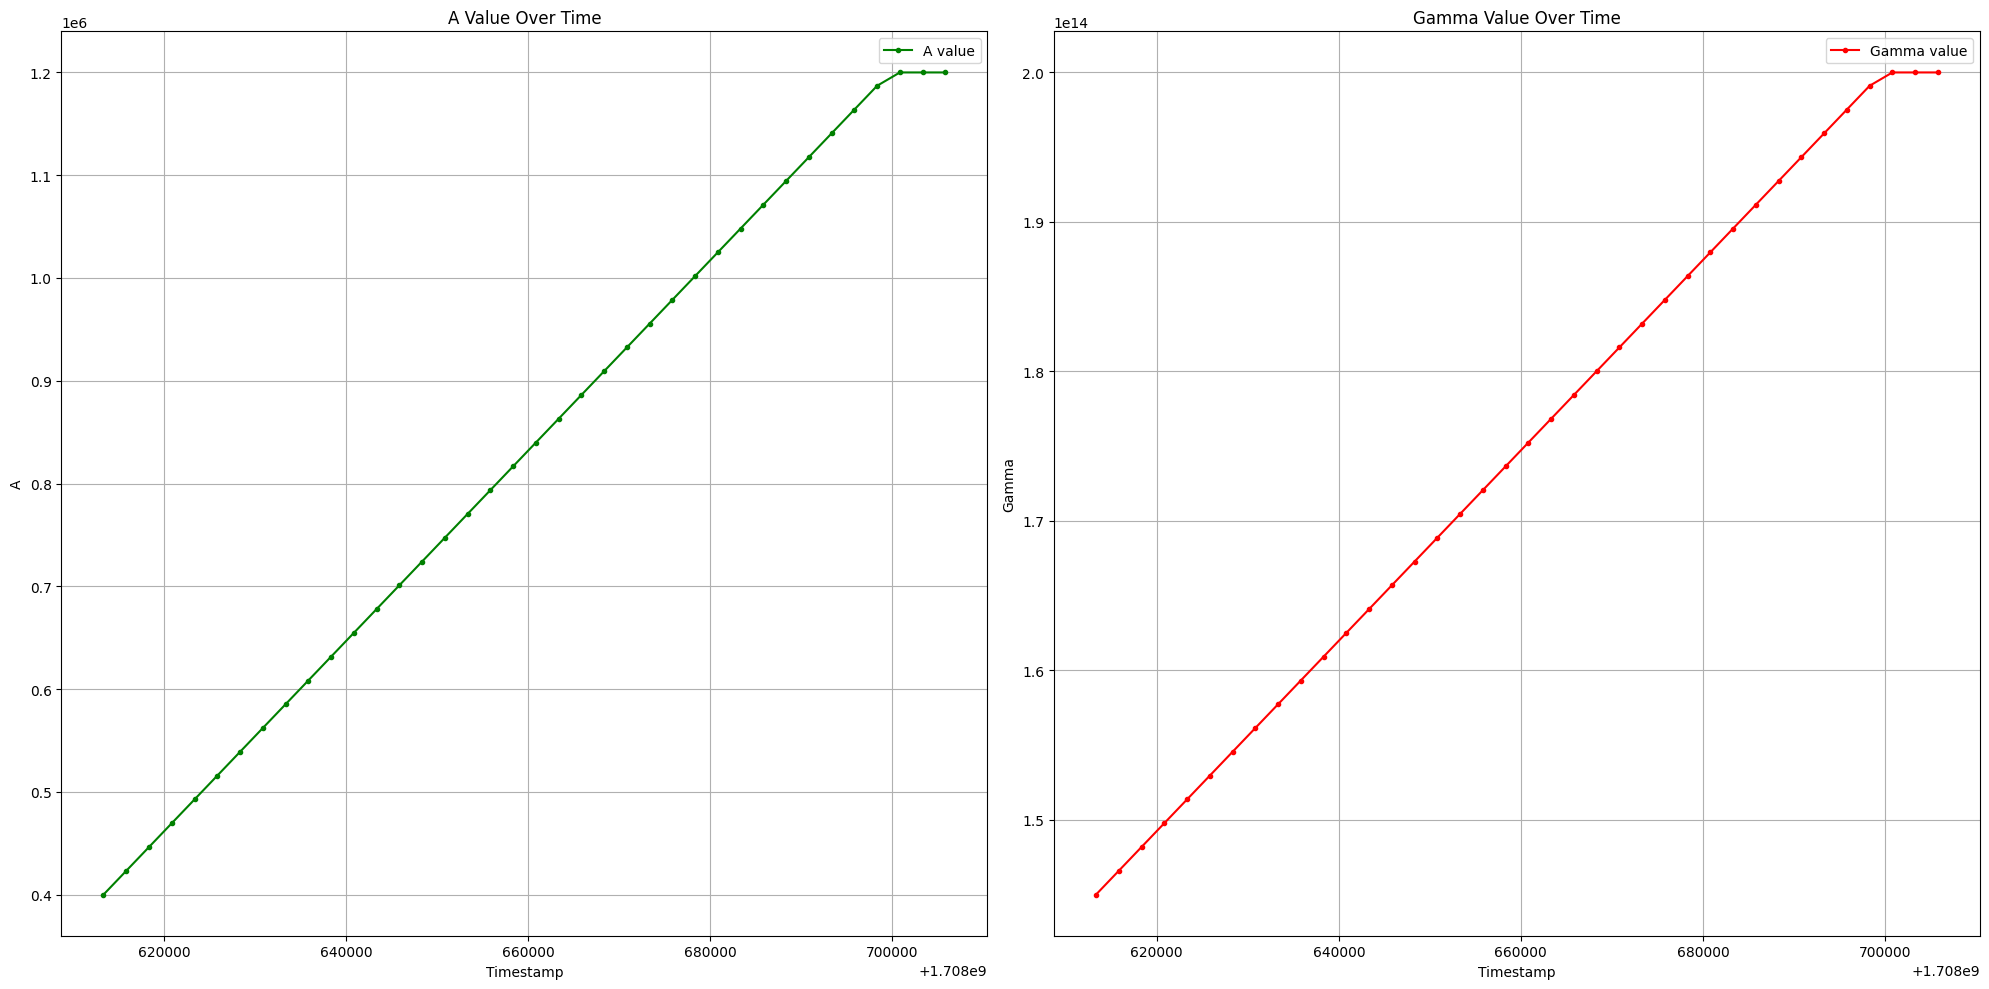

In [4]:
plt.figure(figsize=(20, 10)) 

# subplot A
plt.subplot(1, 2, 1)
plt.plot(timestamps, A, label='A value', color='green', marker='.')
plt.xlabel('Timestamp')
plt.ylabel('A')
plt.title('A Value Over Time')
plt.legend()
plt.grid(True)

# subplot gamma
plt.subplot(1, 2, 2)
plt.plot(timestamps, gamma, label='Gamma value', color='red', marker='.')
plt.xlabel('Timestamp')
plt.ylabel('Gamma')
plt.title('Gamma Value Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


*Observations:*

- A and gamma are ramping up linearly as intended, over a duration of one day (86400 seconds).
- After one day, the ramping stops, and the values of both A and gamma remain constant.


---

### **3. Stop Ramping A and Gamma**

- #### `stop_ramp_A_gamma():`
    This function is designed to immediately stop the ramping of the A and gamma parameters, keeping them at their current values.

Again, this action can only be executed by the Factory `admin` through the `stop_ramp_A_gamma` function.

To demonstrate this functionality, let's initiate the ramping of A and gamma once more to then stop it:


In [5]:
ts = boa.env.vm.patch.timestamp

# initial values before ramping
print("before ramp: A =", pool.A())
print("before ramp: gamma =", pool.gamma())
print("----------")

# Ramping A and gamma
try:
    with boa.env.prank(admin):
        pool.ramp_A_gamma(1600000, 400000000000000, ts + 86400)
    print("Ramping initiated.")
except Exception as e:
    print(f"Failed to initiate ramping: {e}")

# time travel exactly half way through the ramping time. this mean that the ramping should be 50% completed.
boa.env.time_travel(43200)

# values while ramping
print("while ramp: A =", pool.A())
print("while ramp: gamma =", pool.gamma())
print("----------")

# Stopping the ramping process
try:
    with boa.env.prank(admin):
        pool.stop_ramp_A_gamma()
    print("Ramping stopped.")
except Exception as e:
    print(f"Failed to stop ramping: {e}")

# time travel after stopping the ramp to check final values
boa.env.time_travel(43200)

# Final values after stopping ramp
print("after stop: A =", pool.A())
print("after stop: gamma =", pool.gamma())


before ramp: A = 1200000
before ramp: gamma = 200000000000000
----------
Ramping initiated.
while ramp: A = 1400000
while ramp: gamma = 300000000000000
----------
Ramping stopped.
after stop: A = 1400000
after stop: gamma = 300000000000000


*Observations:*

- Ramping was initiated, and both A and gamma were increasing. The decision was made to stop the ramping precisely at the midpoint of the process. This aligns perfectly with the values of `A` and `gamma`:

- The goal was to increase A from 1200000 to 1600000, a total increase of 400000. Given that the ramping process is linear and was stopped exactly halfway through, A was increased by half of the total intended increase, equating to 200000. The same rationale applies to the adjustment of the gamma value.

- We also verified the values of A and gamma at the point when the ramping process would have concluded, had we not intervened to stop it. The findings indicated that the values did not further increase, affirming the halt of the ramping process.

---

### **4. Applying New Parameters**

Applying new parameters can only be done by the `admin` of the factory, which, in essence, is the Curve DAO.

- #### `apply_new_parameters(_new_mid_fee: uint256, _new_out_fee: uint256, _new_fee_gamma: uint256, _new_allowed_extra_profit: uint256, _new_adjustment_step: uint256, _new_ma_time: uint256, _new_xcp_ma_time: uint256):`"

    This function is designed to update the pool's parameters to new values. Unlike other processes that may involve ramping or delays, the application of these new parameters is immediate. There is no waiting period, ensuring that changes take effect without any delay.


    Emits: `NewParameters`

    | Input                   | Type      | Description                                         |
    | ----------------------- | --------- | --------------------------------------------------- |
    | `_new_mid_fee`          | `uint256` | New `mid_fee` value.                                |
    | `_new_out_fee`          | `uint256` | New `out_fee` value.                                |
    | `_new_fee_gamma`        | `uint256` | New `fee_gamma` value.                              |
    | `_new_allowed_extra_profit` | `uint256` | New `allowed_extra_profit` value.               |
    | `_new_adjustment_step`  | `uint256` | New `adjustment_step` value.                        |
    | `_new_ma_time`          | `uint256` | New `ma_time` value, which is seconds/ln(2).|
    | `_new_xcp_ma_time`      | `uint256` | New ma time for xcp oracles.                        |

In [6]:
def print_pool_parameters(title, pool):
    print(title)
    print("mid_fee: " + str(pool.mid_fee()))
    print("out_fee: " + str(pool.out_fee()))
    print("fee_gamma: " + str(pool.fee_gamma()))
    print("allowed_extra_profit: " + str(pool.allowed_extra_profit()))
    print("adjustment_step: " + str(pool.adjustment_step()))
    print("ma_time: " + str(pool.ma_time()))
    print("xcp_ma_time: " + str(pool.xcp_ma_time()))

print_pool_parameters("BEFORE APPLYING NEW PARAMETERS:", pool)
print("------------------------")

try:
    with boa.env.prank(admin):
        pool.apply_new_parameters(
            30000000, # _new_mid_fee
            45000000, # _new_out_fee
            300000000000000, # _new_fee_gamma
            3000000000000, # _new_allowed_extra_profit
            170000000000000, # _new_adjustment_step
            865, # _new_ma_time
            1800 * 24, # _new_xcp_ma_time
        )   
except Exception as e:
    print(f"Failed to apply new parameters: {e}")

print_pool_parameters("AFTER APPLYING NEW PARAMETERS:", pool)

BEFORE APPLYING NEW PARAMETERS:
mid_fee: 26000000
out_fee: 45000000
fee_gamma: 230000000000000
allowed_extra_profit: 2000000000000
adjustment_step: 146000000000000
ma_time: 600
xcp_ma_time: 62324
------------------------
AFTER APPLYING NEW PARAMETERS:
mid_fee: 30000000
out_fee: 45000000
fee_gamma: 300000000000000
allowed_extra_profit: 3000000000000
adjustment_step: 170000000000000
ma_time: 600
xcp_ma_time: 43200


As intended, parameters take immediate effect.